In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('../data/processed/train_processed.csv')

In [3]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [5]:
# SPLIT TRAIN AND TEST
# We keep 20% of data aside to test if our model actually works
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Note: stratify=y ensures that both Train and Test have exactly 8% defaulters. Very important!

In [6]:
print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (246008, 249)
Test Data Shape: (61503, 249)


In [7]:
import re

# 1. CLEAN COLUMN NAMES
# We use Regex to replace any character that is NOT a letter or number with '_'
clean_columns = [re.sub(r'[^\w]', '_', col) for col in X_train.columns]

# Apply to both Train and Test
X_train.columns = clean_columns
X_test.columns = clean_columns

print("Column names cleaned!")

Column names cleaned!


Restoring the Champion Model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's auc: 0.769217

Final AUC Score: 0.7692


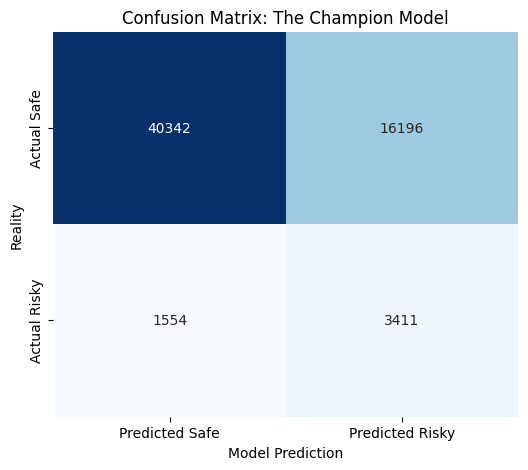


------------------------------------------------------
CLASSIFICATION REPORT (Precision & Recall)
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56538
         1.0       0.17      0.69      0.28      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503

Champion Model saved as 'models/final_model_lgbm.joblib'


In [8]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. RE-TRAIN THE CHAMPION (The "Manual" settings that got 0.7692)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,       
    'learning_rate': 0.05,  # The aggressive learning rate
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'is_unbalance': True,   # Important: Handles the class imbalance
    'verbose': -1
}

d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test, reference=d_train)

print("Restoring the Champion Model...")
lgb_model_final = lgb.train(
    params,
    d_train,
    num_boost_round=1000,
    valid_sets=[d_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 2. GENERATE PREDICTIONS
# LightGBM gives probabilities (0.1, 0.9, etc.)
y_prob = lgb_model_final.predict(X_test)

# We convert probabilities to clean 0 or 1. 
# Threshold = 0.5 (Standard)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

# 3. SCORE CHECK
print(f"\nFinal AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 4. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Safe', 'Predicted Risky'],
            yticklabels=['Actual Safe', 'Actual Risky'])
plt.title("Confusion Matrix: The Champion Model")
plt.ylabel("Reality")
plt.xlabel("Model Prediction")
plt.show()

# 5. CLASSIFICATION REPORT
print("\n------------------------------------------------------")
print("CLASSIFICATION REPORT (Precision & Recall)")
print("------------------------------------------------------")
print(classification_report(y_test, y_pred))

# 6. SAVE IT (Overwriting with the best version)
joblib.dump(lgb_model_final, '../models/final_model_lgbm.joblib')
print("Champion Model saved as 'models/final_model_lgbm.joblib'")

In [11]:
!pip install shap


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Ronak Sumrani\My Projects\Credit_Risk_Project\venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


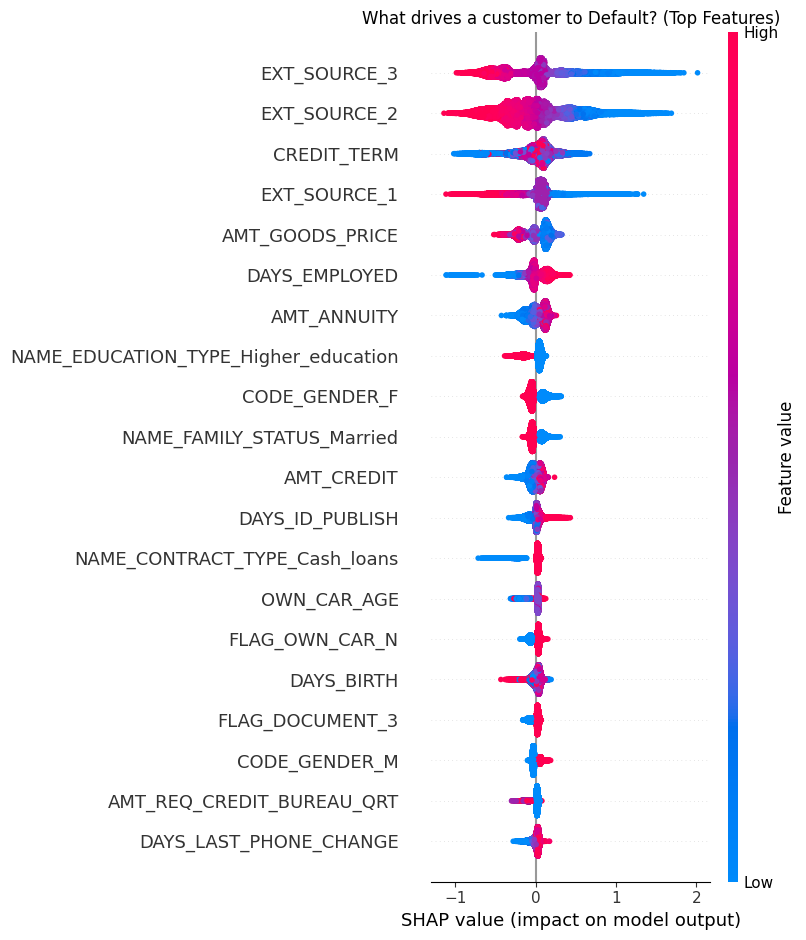

In [13]:
import shap
import matplotlib.pyplot as plt

# 1. Create the Explainer
explainer = shap.TreeExplainer(lgb_model_final)
shap_values = explainer.shap_values(X_test)

# 2. Check the shape (Debugging step)
# If it's a list, we take [1]. If it's an array, we use it directly.
if isinstance(shap_values, list):
    shap_vals_to_plot = shap_values[1]
else:
    shap_vals_to_plot = shap_values

# 3. The Summary Plot
plt.title("What drives a customer to Default? (Top Features)")
shap.summary_plot(shap_vals_to_plot, X_test, plot_type="dot")